# Support Vector Machine

An alternative model to Random Forest.

In [9]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split

In [10]:
games = pd.read_csv('../data/last10g_ELOk32.csv')

In [11]:
# split
y = games['HOME_TEAM_WINS']

names = games.columns
X = games[names.delete(names.get_loc(y.name))]  # all the columns not in y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# model fit
clf = svm.SVC(C=100.0, kernel='rbf', probability=True, max_iter=100000)

In [13]:
clf.fit(X_train, y_train)

SVC(C=100.0, max_iter=100000, probability=True)

In [14]:
# monitoring iterations
def confusion_matrix_data(model, X_test, y_test, name):
    """
    Compute the confusion matrix of the given model.
    Export a graph for the matrix. 
    Return confusion matrix array containing tn, fp, fn and tp.
    """
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=model.classes_)
    # export graph
    disp.plot()
    plt.savefig(fname='../iterations_evaluation/'+name+'_confusion_matrix')

    return cm

def fpr_fnr_data(cm):
    """
    Compute False Positive Rate and False Negative Rate from confusion matrix.
    """
    # the confusion matrix has True Negative, False Positive, False Negative 
    # and True Positive info.
    tn, fp, fn, tp = cm.ravel() # .ravel() flattens the array to a 1-Dimension array

    # To get the total number of wins and losses we count the ones and zeroes, 
    # respectively, from the Target variable.
    wins, losses = y.value_counts()

    fpr = fp/losses     # FPR = FP/N
    fnr = fn/wins       # FNR = FN/P

    return fpr, fnr

from sklearn.metrics import auc, roc_curve, RocCurveDisplay

def roc_data(y, pred, name):
    """
    Compute ROC information for the given model. 
    Export a graph for the curve. Return AUC value.
    """
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='wins')
    # export graph
    display.plot()
    plt.savefig(fname='../iterations_evaluation/'+name+'_roc')

    return roc_auc

import matplotlib.pyplot as plt
import json
from os import path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay

def indexes(model, y, X_test, y_test, name):
    """
    Compute accuracy, FPR, FNR, confusion matrix and ROC curve.
    Exports two images, one for the confusion matrix anthe other for ROC; 
    all other indexes are added to a json file.
    """
    # Indexes computation
    accuracy = model.score(X_test, y_test)                  # accuracy
    cm = confusion_matrix_data(model, X_test, y_test, name) # confusion matrix
    fpr, fnr = fpr_fnr_data(cm)                             # False Positive Rate, False Negative Rate
    area_under_curve = roc_data(y, model.predict_proba(X)[:, 1], name)   # Receiver Operating Characteristic curve and Area Under the Curve
    
    # Indexes export handling
    json_filename = '../iterations_evaluation/iterations.json'

    if path.isfile(json_filename) is True:  # file exists
        # get json file
        with open(file=json_filename,mode='r') as f: # read mode
            all_indexes = json.load(f)  # json file is translated to a python dictionary
    else:   # file does not exists
        with open(file=json_filename,mode='x') as f: # create mode
            all_indexes = dict()    # create an empty dictionary
    # add new indexes to dictionary
    all_indexes.update({
        name: {
            'accuracy': accuracy,
            'confusion_matrix': [x.item() for x in cm.ravel()], # cm is numpy.ndarray and its elements are numpy.int64; both types aren't "JSON Serialiazable" so they have to be translated to native Python types
            'FPR': fpr,
            'FNR': fnr,
            'AUC': area_under_curve
        }
    })
    # rewrite file with new indexes
    with open(file=json_filename,mode='w') as f:
        json.dump(all_indexes, f, indent=4, separators=(',',': '))
    
    return accuracy, cm, fpr, fnr, area_under_curve

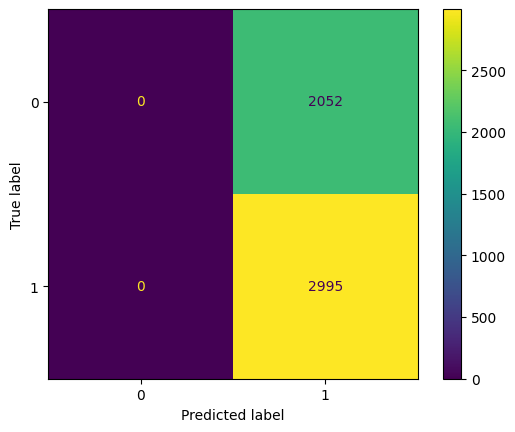

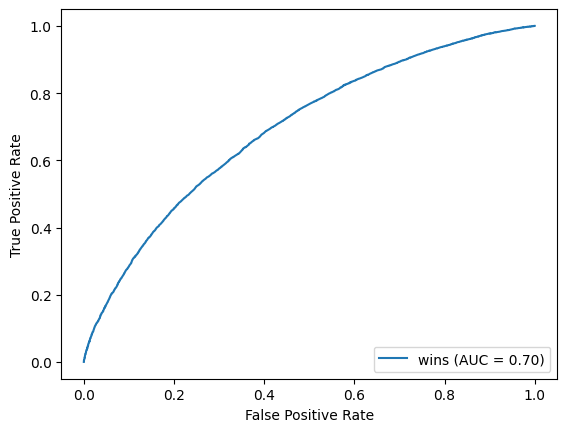

In [15]:
accuracy, cm, fpr, fnr, area_under_curve = indexes(model=clf, y=y, X_test=X_test, y_test=y_test, name='last10g_ELOk32_SVC')

In [4]:
# hyper-parameter tuning 
# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    svm.SVC(kernel='rbf'),
    param_grid={"C": [10, 100, 500]},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 5000)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["C"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [15]:
clf.get_params()

{'C': 1000.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}